In [6]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import random
import math
from tqdm import tqdm

from DynamicalSystemLayer import *
from VaeNeuralODELayer import *

# Data generation

In [49]:
p = torch.Tensor([[0., 1., -0.05, 0]])
z0 = torch.Tensor([[0., 1.]])

times = torch.from_numpy(np.arange(0,200))

ode_true = VaeNeuralODE(LinearODEF(p))
obs = ode_true(z0, times, return_whole_sequence=True).detach()
obs = obs.squeeze(1)

In [40]:
obs.shape

torch.Size([200, 1, 2])

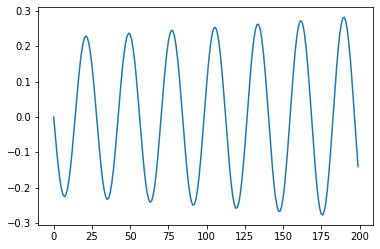

In [41]:
plt.plot(obs[:,:,0].numpy())
plt.show()

In [3]:
pend_data = obs[:,0]
window_len = 5
window_set = pend_data.view(40, 5)
times_set = times.view(40, 5)

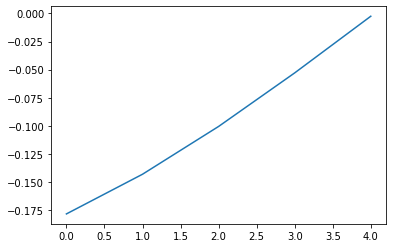

In [63]:
plt.plot(window_set[:,10].numpy())
plt.show()

# Model

In [128]:
class LinearODEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x0, t, A):
        time_len = t.size(0)
        x_dim = x0.size(0) #x_dim = 2
        z = torch.zeros(time_len, 2)
        z0 = x0
        
        with torch.no_grad():
            for it in range(time_len-1):
                h = t[it+1] - t[it]
                z0 = z0 + h*A.matmul(z0)
                z[it+1] = z0
        ctx.save_for_backward(z.clone(), t, A)  
        return z
    
    @staticmethod
    def backward(ctx, grad_out):
        z, t, A = ctx.saved_tensors
        time_len = t.size(0)
        z_dim = z.size(1)
        n_param = A.view(-1).shape[0]
        grad_in = grad_out.clone()
        
        
        adzdA = torch.zeros(time_len, z_dim, n_param)
        
        u = adzdA[0]
        
        for it in range(time_len - 1):
            zi = z[it]
            ti = t[it]
            ai = grad_in[it]
            
            adfdz = ai.matmul(A)
            adfdA = ai.matmul(zi)
            
            h = t[it+1] -ti
            u = u + h*(adfdz.matmul(u) + adfdA)
            
            adzdA[it+1] = u
        return adzdA, None, None
         

In [90]:
#for later
class LinearODELayer(nn.Module):
    def __init__(self, data_dim):
        super(LinearODELayer, self).__init__()
        self.data_dim = data_dim
        
        self.weight = torch.randn(4, requires_grad=True)
        
        self.A = self.weight.reshape(2,2).requires_grad_(True)
        
    def forward(self, x, t):
        z0 = torch.Tensor([x[0], x[1]])
        z = LinearODEFunction.apply(z0, t, self.A)
        return z

# Training

In [126]:
dtype = torch.float
device = torch.device("cpu")

p = torch.Tensor([[0., 1., -0.05, 0]])
z0 = torch.Tensor([[0., 1.]])

times = torch.from_numpy(np.arange(0,200))

ode_true = VaeNeuralODE(LinearODEF(p))
obs = ode_true(z0, times, return_whole_sequence=True).detach()
obs = obs.squeeze(1)

pend_data = obs
window_len = 5
window_set = pend_data.view(40, 5, 2)
times_set = times.view(40, 5)



test_set = window_set[30:, :, :]
train_set = window_set[:30,:, :]

test_time = times_set[30:]
train_time = times_set[:30]

train_sample = train_set.shape[1]
test_sample = test_set.shape[1]

A = torch.randn(2,2, device=device, dtype=dtype, requires_grad=True)

Hello
start training
epoch: 1
train_loss: 7539.229705810547
test_loss: 13961.020034790039
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)


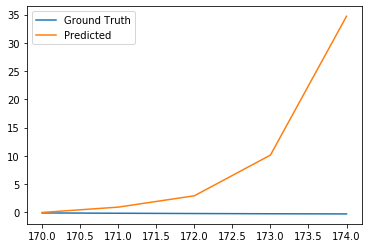

epoch: 2
train_loss: 15078.459411621094
test_loss: 27922.040069580078
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 3
train_loss: 22617.68911743164
test_loss: 41883.06010437012
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 4
train_loss: 30156.918823242188
test_loss: 55844.080139160156
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 5
train_loss: 37696.148529052734
test_loss: 69805.1001739502
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 6
train_loss: 45235.37823486328
test_loss: 83766.12020874023
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 7
train_loss: 52774.60794067383
test_loss: 97727.14024353027
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 8
train_loss: 60313.837646484375
test_los

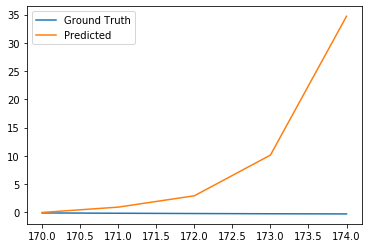

epoch: 12
train_loss: 90470.75646972656
test_loss: 167532.24041748047
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 13
train_loss: 98009.98617553711
test_loss: 181493.2604522705
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 14
train_loss: 105549.21588134766
test_loss: 195454.28048706055
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 15
train_loss: 113088.4455871582
test_loss: 209415.3005218506
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 16
train_loss: 120627.67529296875
test_loss: 223376.32055664062
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 17
train_loss: 128166.9049987793
test_loss: 237337.34059143066
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 18
train_loss: 135706.13470458984

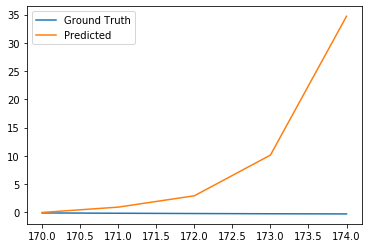

epoch: 22
train_loss: 165863.05352783203
test_loss: 307142.44076538086
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 23
train_loss: 173402.28323364258
test_loss: 321103.4608001709
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 24
train_loss: 180941.51293945312
test_loss: 335064.48083496094
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 25
train_loss: 188480.74264526367
test_loss: 349025.500869751
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 26
train_loss: 196019.97235107422
test_loss: 362986.520904541
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 27
train_loss: 203559.20205688477
test_loss: 376947.54093933105
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 28
train_loss: 211098.4317626953

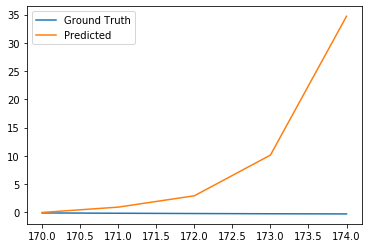

epoch: 32
train_loss: 241255.3505859375
test_loss: 446752.64111328125
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 33
train_loss: 248794.58029174805
test_loss: 460713.6611480713
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 34
train_loss: 256333.8099975586
test_loss: 474674.6811828613
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 35
train_loss: 263873.03970336914
test_loss: 488635.70121765137
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 36
train_loss: 271412.2694091797
test_loss: 502596.7212524414
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 37
train_loss: 278951.49911499023
test_loss: 516557.74128723145
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 38
train_loss: 286490.7288208008


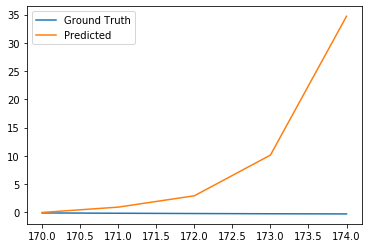

epoch: 42
train_loss: 316647.64764404297
test_loss: 586362.8414611816
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 43
train_loss: 324186.8773498535
test_loss: 600323.8614959717
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 44
train_loss: 331726.10705566406
test_loss: 614284.8815307617
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 45
train_loss: 339265.3367614746
test_loss: 628245.9015655518
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 46
train_loss: 346804.56646728516
test_loss: 642206.9216003418
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 47
train_loss: 354343.7961730957
test_loss: 656167.9416351318
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 48
train_loss: 361883.02587890625
te

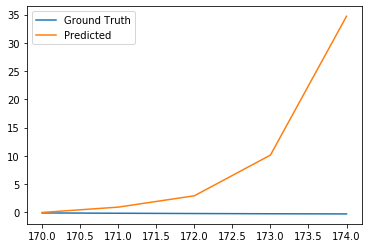

epoch: 52
train_loss: 392039.94470214844
test_loss: 725973.041809082
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 53
train_loss: 399579.174407959
test_loss: 739934.0618438721
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 54
train_loss: 407118.40411376953
test_loss: 753895.0818786621
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 55
train_loss: 414657.6338195801
test_loss: 767856.1019134521
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 56
train_loss: 422196.8635253906
test_loss: 781817.1219482422
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 57
train_loss: 429736.0932312012
test_loss: 795778.1419830322
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 58
train_loss: 437275.3229370117
test_l

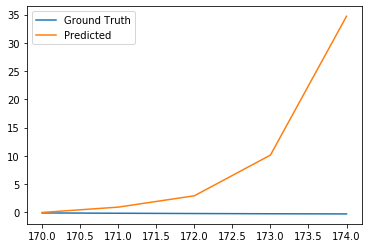

epoch: 62
train_loss: 467432.2417602539
test_loss: 865583.2421569824
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 63
train_loss: 474971.47146606445
test_loss: 879544.2621917725
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 64
train_loss: 482510.701171875
test_loss: 893505.2822265625
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 65
train_loss: 490049.93087768555
test_loss: 907466.3022613525
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 66
train_loss: 497589.1605834961
test_loss: 921427.3222961426
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 67
train_loss: 505128.39028930664
test_loss: 935388.3423309326
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 68
train_loss: 512667.6199951172
test

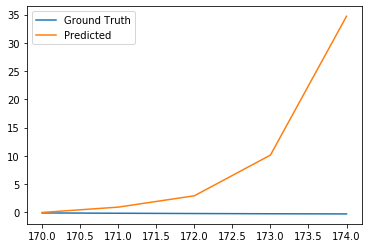

epoch: 72
train_loss: 542824.5388183594
test_loss: 1005193.4425048828
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 73
train_loss: 550363.7685241699
test_loss: 1019154.4625396729
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 74
train_loss: 557902.9982299805
test_loss: 1033115.4825744629
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 75
train_loss: 565442.227935791
test_loss: 1047076.5026092529
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 76
train_loss: 572981.4576416016
test_loss: 1061037.522644043
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 77
train_loss: 580520.6873474121
test_loss: 1074998.542678833
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 78
train_loss: 588059.9170532227
tes

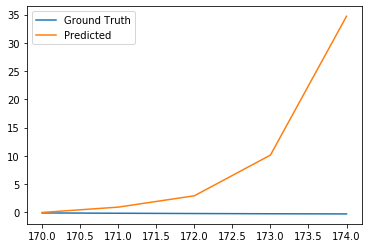

epoch: 82
train_loss: 618216.8358764648
test_loss: 1144803.6428527832
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 83
train_loss: 625756.0655822754
test_loss: 1158764.6628875732
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 84
train_loss: 633295.2952880859
test_loss: 1172725.6829223633
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 85
train_loss: 640834.5249938965
test_loss: 1186686.7029571533
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 86
train_loss: 648373.754699707
test_loss: 1200647.7229919434
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 87
train_loss: 655912.9844055176
test_loss: 1214608.7430267334
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 88
train_loss: 663452.2141113281
t

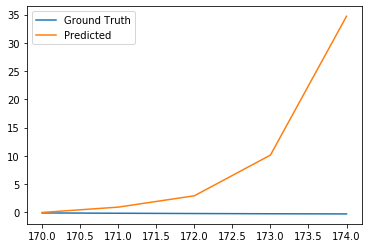

epoch: 92
train_loss: 693609.1329345703
test_loss: 1284413.8432006836
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 93
train_loss: 701148.3626403809
test_loss: 1298374.8632354736
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 94
train_loss: 708687.5923461914
test_loss: 1312335.8832702637
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 95
train_loss: 716226.822052002
test_loss: 1326296.9033050537
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 96
train_loss: 723766.0517578125
test_loss: 1340257.9233398438
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 97
train_loss: 731305.281463623
test_loss: 1354218.9433746338
predicted A:
tensor([[ 1.6771,  0.9938],
        [ 2.1759, -0.4803]], requires_grad=True)
epoch: 98
train_loss: 738844.5111694336
te

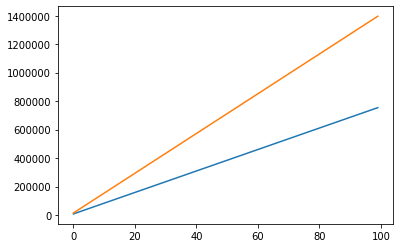

In [131]:
print('Hello')
learning_rate = 0.1
train_loss = 0
test_loss = 0
train_loss_store = []
test_loss_store = []

print('start training')
for epoch in range(100):
    ode = LinearODEFunction.apply
    
    for n in range(train_sample):
        ytrain = train_set[n,:,:]
        z0 = ytrain[0]
        t = train_time[n,:]
        ztrain = ode(z0, t, A)
        
        loss = ((ztrain - ytrain).norm(p=2)).pow(2).sum()
        train_loss += loss.item()
        loss.backward()
        
        with torch.no_grad():
            A -= learning_rate*A.grad
            A.grad.zero_()
            
    for n in range(test_sample):
        with torch.no_grad():
            ytest = test_set[n,:,:]
            z0 = ytest[0]
            t = test_time[n,:]
            ztest = ode(z0, t, A)
            
            loss = ((ztest - ytest).norm(p=2)).pow(2).sum()
            test_loss += loss.item()
            
    train_loss_store.append(train_loss)
    test_loss_store.append(test_loss)
    print('epoch:', epoch+1)
    print('train_loss:', train_loss)
    print('test_loss:', test_loss)
    print('predicted A:')
    print(A)
    if epoch%10 == 0:
        plt.plot(t.numpy(), ytest[:,0].detach().numpy(), label='Ground Truth')
        plt.plot(t.numpy(), ztest[:,0].detach().numpy(), label='Predicted');
        plt.legend()
        plt.show()
print('...training complete')        
plt.plot(train_loss_store, label='training loss')
plt.plot(test_loss_store, label='test loss')
plt.show()
    